In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("../")

In [4]:
from src.rand_augment import RandAugment

In [5]:
base_dir = Path("../dataset/train")

In [13]:
randaugment = RandAugment({'N':4, 'M':6, 'seed':47})
print(randaugment.augment_list)

[(<function Rotate at 0x00000211560A9D38>, -30, 30), (<function ColorJitter at 0x00000211560BA708>, 0, 0), (<function Cutout at 0x00000211560BA3A8>, 0, 0.2), (<function RandomHorizontalFlip at 0x00000211560BA558>, 0, 1), (<function RandomVerticalFlip at 0x00000211560BA5E8>, 0, 1), (<function RandomResizedCropWrap at 0x00000211560BA678>, 0.0, 0.3), (<function Brightness at 0x00000211560BA048>, 1.0, 1.5), (<function Sharpness at 0x00000211560BA0D8>, 1.0, 1.5), (<function ShearX at 0x00000211560BA168>, -0.1, 0.1), (<function ShearY at 0x00000211560BA1F8>, -0.1, 0.1), (<function TranslateX at 0x00000211560BA288>, -0.1, 0.1), (<function TranslateY at 0x00000211560BA318>, -0.1, 0.1)]


In [14]:
print(randaugment.augments)

[(<function RandomResizedCropWrap at 0x00000211560BA678>, 0.0, 0.3), (<function ColorJitter at 0x00000211560BA708>, 0, 0), (<function Brightness at 0x00000211560BA048>, 1.0, 1.5), (<function ShearX at 0x00000211560BA168>, -0.1, 0.1)]


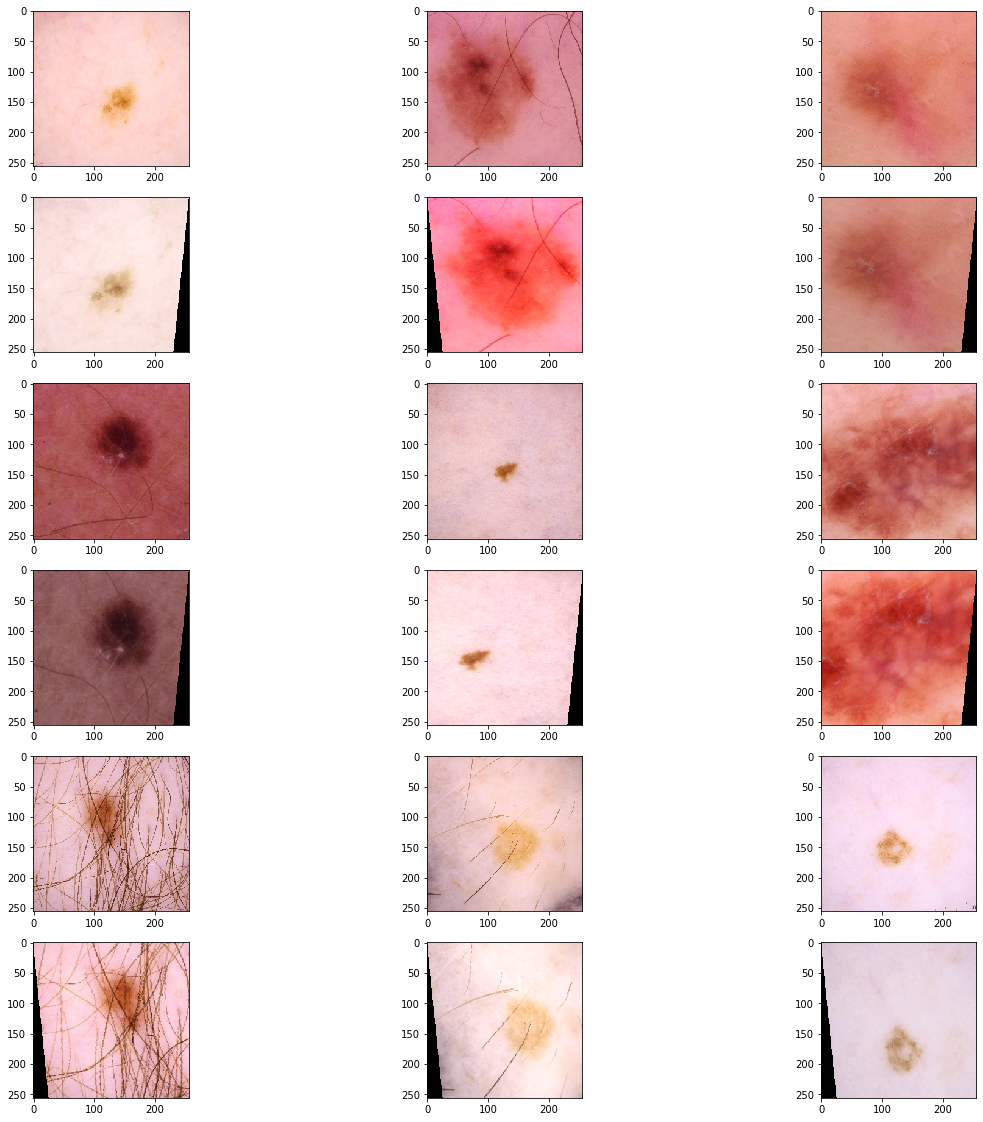

In [15]:
num_images = 9

paths = np.random.choice(list(base_dir.glob("*.jpg")), num_images)

row, col = 0, 0
original_img, transformed_img = [], []

fig, axs = plt.subplots(6, 3, figsize=(20,20))

for i in range(num_images):

    img = Image.open(paths[i].as_posix())
    original_img.append(np.array(img))
    
    tf_img = randaugment(img)
    transformed_img.append(np.array(tf_img))

    axs[row][col].imshow(img)
    axs[row + 1][col].imshow(tf_img)
    
    col += 1
    
    if col >= 3:
        col = 0
        row += 2

plt.show()    

In [16]:
original_img = np.array(original_img)
transformed_img = np.array(transformed_img)

print(original_img.shape)
print(transformed_img.shape)

(9, 256, 256, 3)
(9, 256, 256, 3)


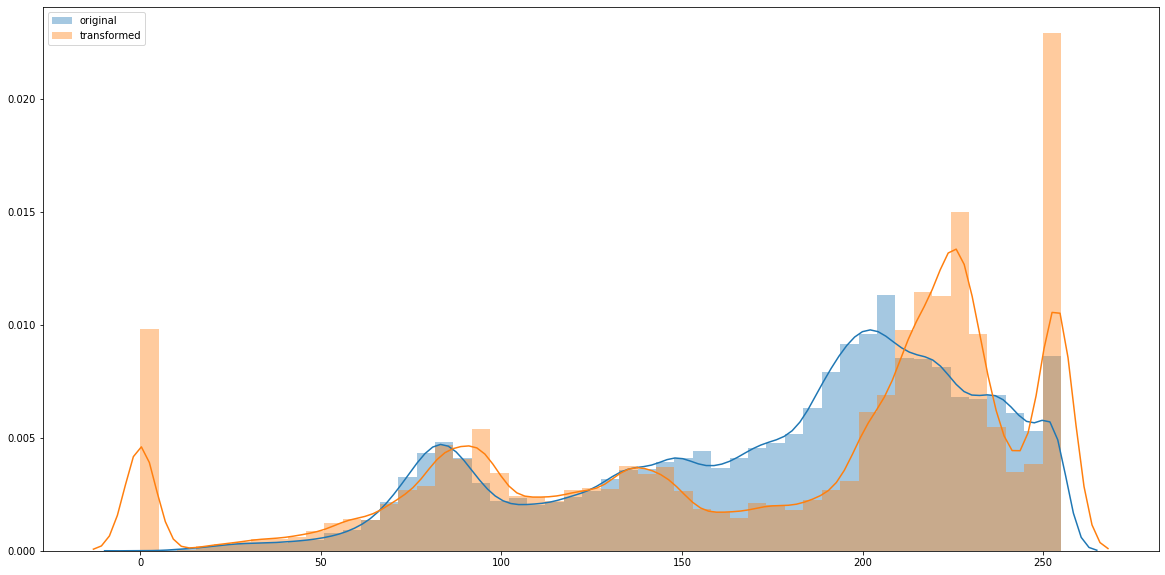

In [17]:
plt.figure(figsize=(20, 10))
sns.distplot(original_img.flatten(), label='original')
sns.distplot(transformed_img.flatten(), label='transformed')

plt.legend()
plt.show()

### Averaging out the Results

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [9]:
dfs = [
    pd.read_csv(x) for x in Path("D:\GitHub\MLMI").glob("submission-raw-inverse-sqrt-fold-*-meta-tta-*")
]

In [10]:
ensemble = pd.DataFrame(columns=dfs[0].columns)
ensemble["image_name"] = dfs[0]["image_name"]
ensemble["target"] = 0.0

In [11]:
for df in dfs:
    df = df[df["image_name"].isin(ensemble["image_name"])]
    ensemble["target"] += df["target"]

In [12]:
ensemble["target"] /= 4
ensemble.to_csv("ensemble-raw-inverse-sqrt-meta-tta.csv", index=False)

### Plots for Presentation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pylab import rcParams
rcParams["figure.figsize"] = (20, 10)

sns.set(style=None)
sns.set(font_scale=1.5)

In [3]:
df = pd.read_csv("experiments.csv")
df.head(2)

,Model,Data Fold,Using Metadata,Test Augment,Unnamed: 4,Rand Augment Param,Unnamed: 6,Magnitude,Loss Criterion,AUC Score,Val AUC Score,Comments
0,NaN,NaN,NaN,Simple,RandAugment,N,M,NaN,NaN,NaN,NaN,NaN
1,B1,4,No,No,No,-,-,-,Inverse Frequency,0.873,0.974,NaN


In [4]:
df.columns = [
    "Model", 
    "Fold",
    "Metadata",
    "Simple TA", 
    "RandAug TA", 
    "N", "M", 
    "Magnitude",
    "Loss", 
    "Test AUC",
    "Val AUC",
    "Comments"
]
df.head(2)

,Model,Fold,Metadata,Simple TA,RandAug TA,N,M,Magnitude,Loss,Test AUC,Val AUC,Comments
0,NaN,NaN,NaN,Simple,RandAugment,N,M,NaN,NaN,NaN,NaN,NaN
1,B1,4,No,No,No,-,-,-,Inverse Frequency,0.873,0.974,NaN


In [5]:
df.drop(0, inplace=True)

In [6]:
df_filter = df[
    (df["Model"] == "B1") &
    (df["Loss"] == "Inverse Sqrt Frequency") &
    (df["RandAug TA"] == "No") &
    (~df["N"].fillna("-").str.isalnum()) & (~df["M"].fillna("-").str.isalnum())
]
df_filter = df_filter.sort_values(["Fold"])

In [11]:
df_filter.to_excel("plot.xlsx")

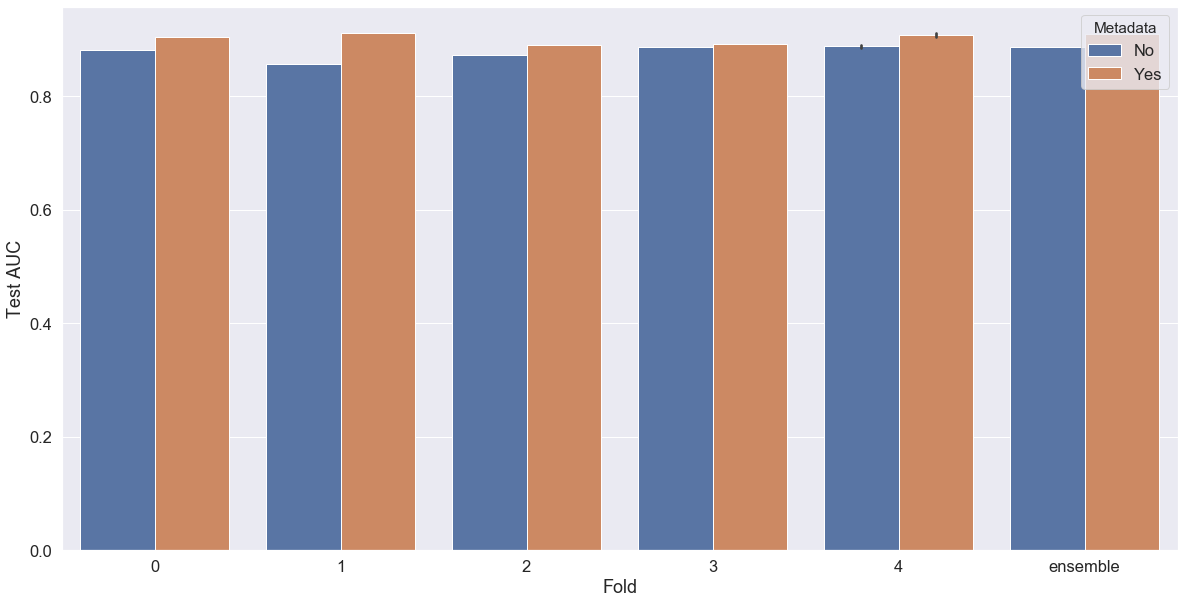

In [7]:
ax = sns.barplot(x="Fold", y="Test AUC", hue="Metadata", data=df_filter)
fig = ax.get_figure()
fig.savefig("AUC-Fold.png") 

In [13]:
## here we discuss the apparent difference between the test set evaluation
## and the validation set for different folds
df_filter = df[
    (df["Model"] == "B1") &
    (df["Loss"] == "Inverse Sqrt Frequency") &
    (df["RandAug TA"] == "No") &
    (~df["N"].fillna("-").str.isalnum()) & (~df["M"].fillna("-").str.isalnum())
]
df_filter = df_filter.sort_values(["Model"])

In [14]:
df_filter = df_filter[["Fold", "Test AUC", "Val AUC"]].melt("Fold", var_name="AUC",
                                                            value_name="AUC Score")

In [15]:
df_filter = df_filter.dropna()[(df_filter["Fold"] != "ensemble")]
df_filter.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Fold,AUC,AUC Score
0,1,Test AUC,0.8576
1,0,Test AUC,0.8823


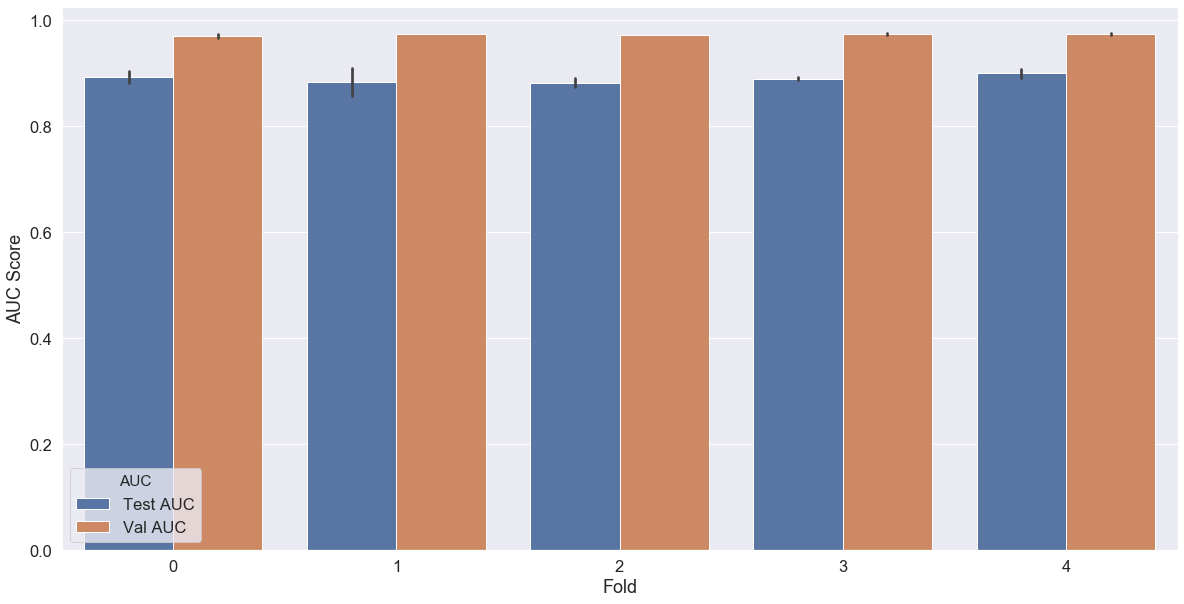

In [16]:
ax = sns.barplot(x="Fold", y="AUC Score", hue="AUC", data=df_filter)
fig = ax.get_figure()
fig.savefig("AUC-Fold-ValTest.png") 

In [28]:
df_filter = df[
    (df["RandAug TA"] == "No") &
    (~df["N"].fillna("-").str.isalnum()) & (~df["M"].fillna("-").str.isalnum())
]
df_filter = df_filter.sort_values(["Model"])

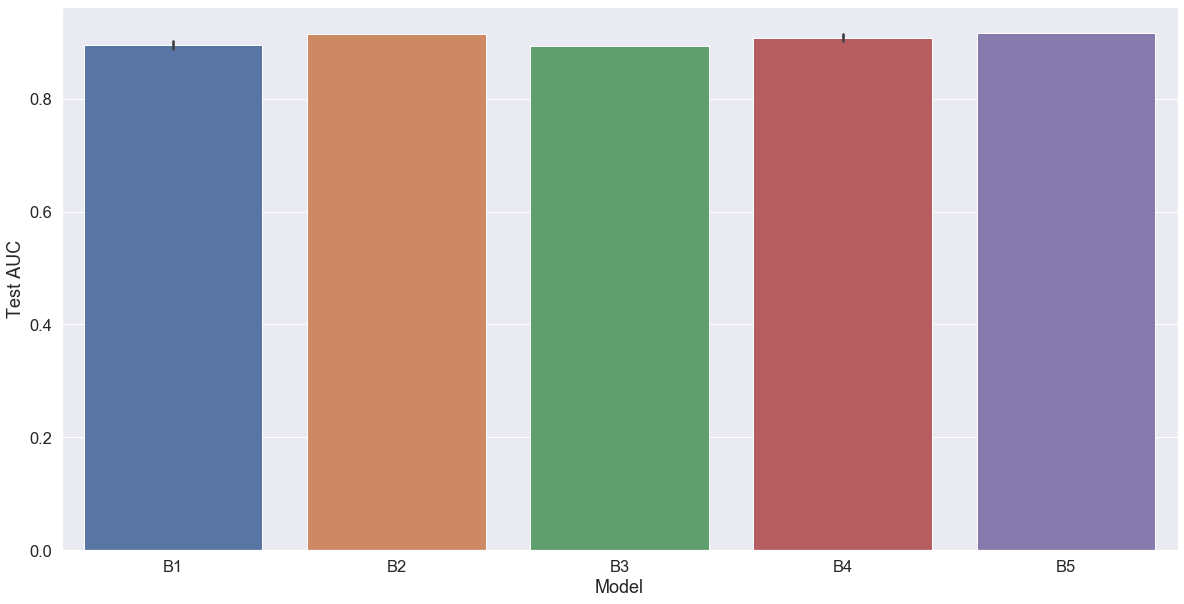

In [30]:
ax = sns.barplot(x="Model", y="Test AUC", data=df_filter)
fig = ax.get_figure()
fig.savefig("AUC-Model-with-TTA-Meta.png") 

In [ ]:
df_filter = df[(df["Metadata"] == "Yes") &
   (df["Simple TA"] == "Yes") &
   (df["RandAug TA"] == "No") &
   (~df["N"].fillna("-").str.isalnum()) & (~df["M"].fillna("-").str.isalnum())
]
df_filter = df_filter.sort_values(["Model"])

In [12]:
## here we can discuss about the effect of changing the transformations. 
## how did we reach to this conclusion: by observing the distribution of 
## test distribution for baseline and the randaugment model
df_filter = df[ 
   (df["Comments"] == "Transformations from paper") | (df["Comments"] == "Changed Transformations") &
   (df["Model"] == "B1") &
   (df["Loss"] == "Inverse Frequency") &
   (df["N"].fillna("-").str.isalnum()) & (df["M"].fillna("-").str.isalnum())
]

df_filter = df_filter.sort_values(["Fold"])

In [13]:
df_filter["N"] = df_filter["N"].astype(int)
df_filter["AUC"] *= 100 
df_filter

,Model,Fold,Metadata,Simple TA,RandAug TA,N,M,Magnitude,Loss,AUC,Val AUC,Comments
10,B1,4,Yes,Yes,No,3,20,Constant,Inverse Frequency,79.47,0.952,Transformations from paper
11,B1,4,Yes,Yes,No,4,13,Constant,Inverse Frequency,79.41,NaN,Transformations from paper
12,B3,4,Yes,Yes,No,3,20,Constant,Inverse Frequency,74.96,0.952,Transformations from paper
13,B1,4,Yes,Yes,No,7,13,Constant,Inverse Frequency,79.38,NaN,Transformations from paper
14,B1,4,No,Yes,No,1,14,Constant,Inverse Frequency,81.56,NaN,Transformations from paper
15,B1,4,No,No,No,1,14,Constant,Inverse Frequency,80.45,NaN,Transformations from paper
16,B1,4,No,No,No,3,10,Constant,Inverse Frequency,84.75,0.974,Changed Transformations
17,B1,4,No,Yes,No,3,10,Constant,Inverse Frequency,86.78,0.974,Changed Transformations
18,B1,4,No,Yes (20),No,3,10,Constant,Inverse Frequency,87.06,0.974,Changed Transformations
19,B1,4,No,Yes,No,4,6,Constant,Inverse Frequency,89.00,0.973,Changed Transformations


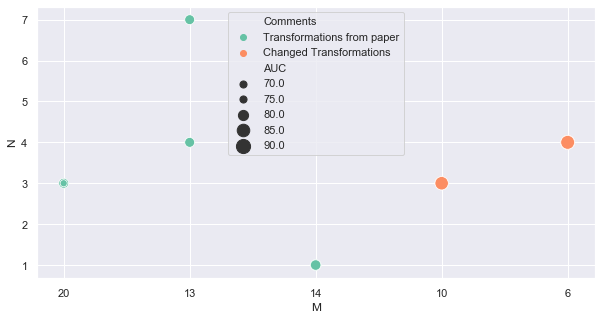

In [14]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(x="M", y="N", size="AUC", hue="Comments", sizes=(50, 200), palette="Set2", data=df_filter)
fig = ax.get_figure()
fig.savefig("AUC-RandAugment-From.png") 

In [24]:
## here we can discuss about the change in the loss implementation
## also why we thought about changing the loss was a good idea
df_filter = df[ 
   (df["Comments"] == "Changed Transformations") &
   (df["Model"] == "B1") &
   (df["N"].fillna("-").str.isalnum()) & (df["M"].fillna("-").str.isalnum())
]

In [26]:
print("Mean AUC for Inverse Frequency: ", df_filter[df_filter["Loss"] == "Inverse Frequency"]["Test AUC"].mean())
print("Mean AUC for Inverse Sqrt Frequency: ", df_filter[df_filter["Loss"] == "Inverse Sqrt Frequency"]["Test AUC"].mean())

Mean AUC for Inverse Frequency:  0.8733571428571428
Mean AUC for Inverse Sqrt Frequency:  0.8710555555555556


In [34]:
df_filter.sort_values(["Loss"])[["Model", "Metadata", "Simple TA", "Magnitude", "N", "M", "Loss", "Test AUC", "Val AUC"]]

,Model,Metadata,Simple TA,Magnitude,N,M,Loss,Test AUC,Val AUC
16,B1,No,No,Constant,3,10,Inverse Frequency,0.8475,0.974
17,B1,No,Yes,Constant,3,10,Inverse Frequency,0.8678,0.974
18,B1,No,Yes (20),Constant,3,10,Inverse Frequency,0.8706,0.974
19,B1,No,Yes,Constant,4,6,Inverse Frequency,0.8900,0.973
20,B1,No,No,Constant,4,6,Inverse Frequency,0.8730,0.973
21,B1,Yes,Yes (20),Constant,4,6,Inverse Frequency,0.8830,0.973
23,B1,No,No,Constant,4,6,Inverse Frequency,0.8816,0.973
22,B1,No,No,Constant,4,6,Inverse Sqrt Frequency,0.8834,0.973
24,B1,No,Yes,Constant,4,6,Inverse Sqrt Frequency,0.8905,0.973
25,B1,No,No,Constant,11,1,Inverse Sqrt Frequency,0.8680,0.973


In [34]:
print("Mean Val AUC for Constant Magnitude: ", np.round(df_filter[df_filter["Magnitude"] == "Constant"]["Val AUC"].mean(),3))
print("Mean Test AUC for Constant Magnitude: ", df_filter[df_filter["Magnitude"] == "Constant"]["Test AUC"].mean())
print("Mean Val AUC for Random Magnitude: ", np.round(df_filter[df_filter["Magnitude"] == "Random"]["Val AUC"].mean(), 3))
print("Mean Test AUC for Random Magnitude: ", df_filter[df_filter["Magnitude"] == "Random"]["Test AUC"].mean())

Mean Val AUC for Constant Magnitude:  0.973
Mean Test AUC for Constant Magnitude:  0.8708
Mean Val AUC for Random Magnitude:  0.973
Mean Test AUC for Random Magnitude:  0.87585


In [ ]:
## we can also check at the effect of adding feature aggregation layer
## we can show the images before and after transform for the varying degree of transformation

### Changing Transformations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from pathlib import Path

without_randaugment = Path("submission-2.csv")
with_randaugment = Path("submission-7.csv")
with_randaugment_less_harsh = Path("submission-19.csv")

df_wo = pd.read_csv(without_randaugment)
df_with = pd.read_csv(with_randaugment)
df_with_less_harsh = pd.read_csv(with_randaugment_less_harsh)

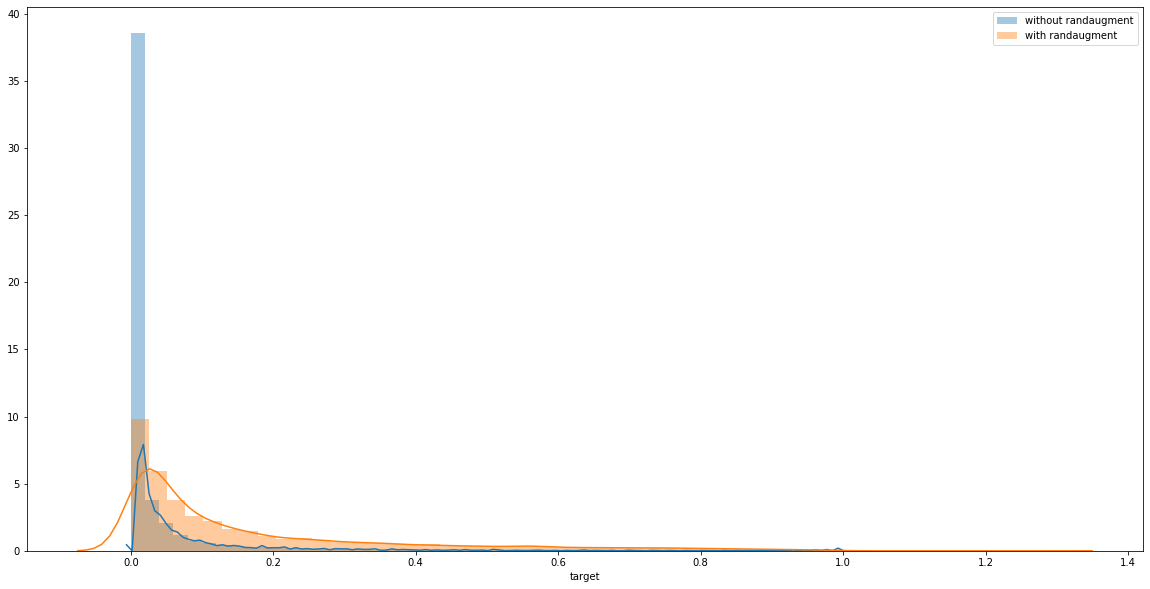

In [14]:
plt.figure(figsize=(20,10))
sns.distplot(df_wo["target"], label="without randaugment")
sns.distplot(df_with["target"], label="with randaugment")
plt.legend()
plt.show()

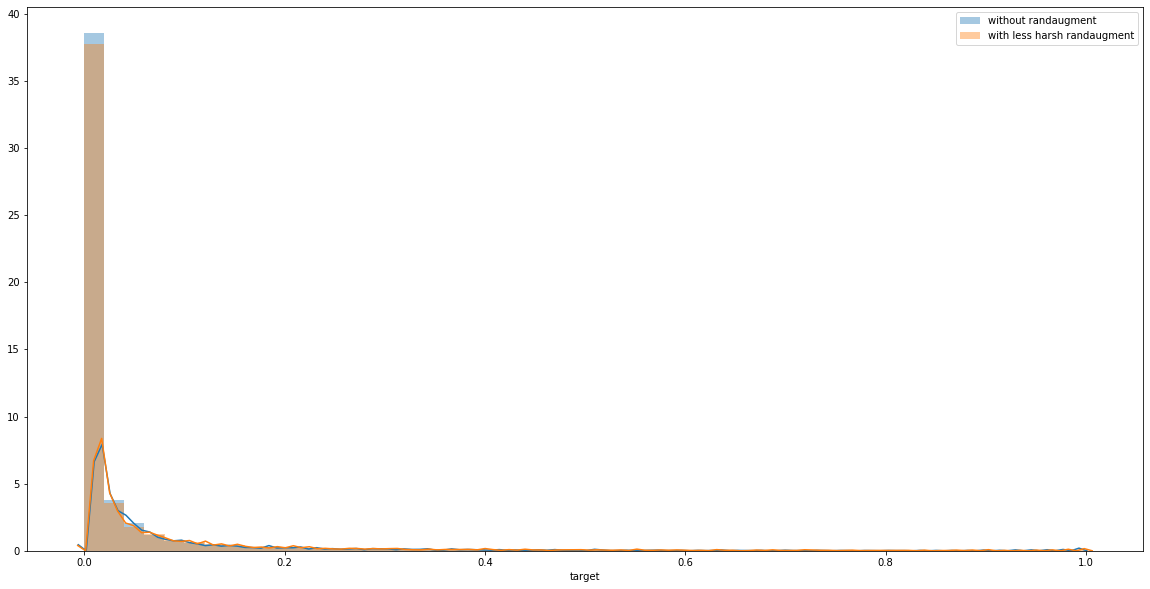

In [15]:
plt.figure(figsize=(20,10))
sns.distplot(df_wo["target"], label="without randaugment")
sns.distplot(df_with_less_harsh["target"], label="with less harsh randaugment")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path

without_randaugment = Path("submission-2.csv")
with_randaugment = Path("submission-7.csv")
with_randaugment_less_harsh = Path("submission-19.csv")

df_wo = pd.read_csv(without_randaugment)
df_with = pd.read_csv(with_randaugment)
df_with_less_harsh = pd.read_csv(with_randaugment_less_harsh)

plt.figure(figsize=(20,10))
sns.distplot(df_wo["target"], label="without randaugment")
sns.distplot(df_with["target"], label="with randaugment")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
sns.distplot(df_wo["target"], label="without randaugment")
sns.distplot(df_with_less_harsh["target"], label="with less harsh randaugment")
plt.legend()
plt.show()